# Resume Classification
## To extract the desired resumes based on the keywords searched.

## Required installations

## Import statements

In [4]:
import zipfile
import os
import re
import string
import nltk
import spacy
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader
from docx import Document
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

## Common Methods
### To extact different types for files in zip file

In [5]:
def extract_zip(zip_path, extract_to):
    """Extract a Zip file to a folder"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extacted '{zip_path}' to '{extract_to}'")

def read_docx(file_path):
    """Reads DOCX files."""
    doc=Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

def read_pdf(file_path):
    """Reads PDF files."""
    reader=PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text+=page.extract_text() or ""
    return text

def read_docs_from_zip(zip_path,extract_to="extracted_files"):
    """ Extracts ZIP and reads docs and PDF files."""
    extract_zip(zip_path,extract_to)

    all_texts = {}
    for root, _, files in os.walk(extract_to):
        for file in files:
            file_path=os.path.join(root,file)
            ext = os.path.splitext(file)[1].lower()

            try:
                if ext == ".docx":
                    all_texts[file]=read_docx(file_path)
                elif ext == ".pdf":
                    all_texts[file]=read_pdf(file_path)
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return all_texts

## Importing dataset and extracting all text.

In [9]:
if __name__ == "__main__":
    zip_file =""
    docs_text=read_docs_from_zip("C:\\Users\\GIFTY\\AppData\\Local\\Temp\\fa22b18c-1c96-46c7-9d42-17efd5f3d195_Resumes.zip.195\\Resumes\\Data set.zip")
    docs_original = []
    for filename,content in docs_text.items():
        print(f"\n===== {filename} =====\n")
        print(content[:500])
        docs_original.append({'file_name':filename,'text':content})

Extacted 'C:\Users\GIFTY\AppData\Local\Temp\fa22b18c-1c96-46c7-9d42-17efd5f3d195_Resumes.zip.195\Resumes\Data set.zip' to 'extracted_files'

===== Requirement document- Document Classification (4).docx =====

Project 602– Resume Classification

Business objective- 
The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention



Milestones: Phase 1




Protocols:
All participants should add here to agreed timelines and timelines will not be extended
All the documentation – Final presentation and R/python code to be submitted before the final presentation day
All the parti

===== Internship_Ravali_Musquare Technologies (1).docx =====

Name: Ravali P 

                                                                             Curriculum Vitae 
                                          Specialization: BE (computer science and Engg)   

 
To utilize my techni

In [10]:
# Describing original dataset shape
df_original = pd.DataFrame(docs_original)
df_original

,file_name,text
0,Requirement document- Document Classification ...,Project 602– Resume Classification\n\nBusiness...
1,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...
2,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...
3,React Developer_Deepakreddy.docx,Kanumuru Deepak Reddy\n\n\n\nCAREER OBJECTIVE:...
4,React Developer_Haripriya.docx,HARIPRIYA BATTINA \nExperience as UI Developer...
5,React Developer_Kamalakar Reddy.docx,KAMALAKAR REDDY. A \nLinked In: https://www.li...
6,React Developer_Naveen sadhu.docx,\nNaveen Sadhu\n\n\nTitle: software developer\...
7,React Developer_Pragnya.docx,\nPRAGNYA PATTNAIK\n \n \n \n Expertise: \n \...
8,React Developer_Sarala Madasu-converted.docx,"\n\n 204,Sri geethika prestige,road number 10..."
9,React Developer_Thirupathiamma.docx,\n\nThirupathamma Balla\n\nSUMMARY:\n\n2.8 yea...


In [11]:
# Char count and Word count before cleaning
df_original['char_count'] = df_original['text'].str.len()
df_original['word_count'] = df_original['text'].str.split().map(len)
df_original

,file_name,text,char_count,word_count
0,Requirement document- Document Classification ...,Project 602– Resume Classification\n\nBusiness...,538,76
1,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...,3498,280
2,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184
3,React Developer_Deepakreddy.docx,Kanumuru Deepak Reddy\n\n\n\nCAREER OBJECTIVE:...,3547,501
4,React Developer_Haripriya.docx,HARIPRIYA BATTINA \nExperience as UI Developer...,2627,406
5,React Developer_Kamalakar Reddy.docx,KAMALAKAR REDDY. A \nLinked In: https://www.li...,2621,358
6,React Developer_Naveen sadhu.docx,\nNaveen Sadhu\n\n\nTitle: software developer\...,1450,193
7,React Developer_Pragnya.docx,\nPRAGNYA PATTNAIK\n \n \n \n Expertise: \n \...,2609,348
8,React Developer_Sarala Madasu-converted.docx,"\n\n 204,Sri geethika prestige,road number 10...",2542,339
9,React Developer_Thirupathiamma.docx,\n\nThirupathamma Balla\n\nSUMMARY:\n\n2.8 yea...,994,133


In [12]:
print(f"Word count before cleaning : \n {df_original['word_count'].describe()}")
print(f"Character count before cleaning : \n {df_original['char_count'].describe()}")

Word count before cleaning : 
 count      54.00000
mean      531.37037
std       329.75367
min        76.00000
25%       327.75000
50%       503.00000
75%       629.75000
max      2038.00000
Name: word_count, dtype: float64
Character count before cleaning : 
 count       54.000000
mean      3950.981481
std       2404.397320
min        538.000000
25%       2612.000000
50%       3590.000000
75%       5023.250000
max      15339.000000
Name: char_count, dtype: float64


## Basic data cleaning and data pre-processing - EDA

### Define cleaning methods

In [13]:
# Step1 : Remove HTMl tags
def remove_html(text):
    return BeautifulSoup(text,"html.parser").get(text)

# Step2 : Remove URLs and Emails.
def remove_urls_emails(text):
    text = re.sub(r'http\S+|www\S+|https\S+','',text)# Urls
    text = re.sub(r'\S+@\S+','',text) # Emails
    return text

# Step3 : Remove Punctuations, numbers and special characters.
def remove_punc_numbers_chars(text):
    text = re.sub(r'\d+','',text)
    return text.translate(str.maketrans('','',string.punctuation))

# Step 4: Tokenize and remove stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def token_and_remove_stopwords(text):
    tokens=word_tokenize(text)
    tokens=[word for word in tokens if word not in stop_words]
    return tokens

# Step 5: Lemmatizing and Stemming running -> run
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def clean_text(text):
    remove_html(text)
    text = text.lower()
    text = remove_urls_emails(text)
    text = remove_punc_numbers_chars(text)
    tokens = token_and_remove_stopwords(text)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GIFTY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GIFTY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\GIFTY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GIFTY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
if __name__ == "__main__":
    zip_file =""
    docs_text=read_docs_from_zip("Resumes.zip")
    docs_cleaned = []
    for filename,content in docs_text.items():
        print(f"\n===== Processed text from {filename} =====\n")
        print(clean_text(content))
        docs_cleaned.append({"filename": filename, "text": clean_text(content)})

Extacted 'Resumes.zip' to 'extracted_files'

===== Processed text from Requirement document- Document Classification (4).docx =====

project – resume classification business objective document classification solution significantly reduce manual human effort hrm achieve higher level accuracy automation minimal human intervention milestone phase protocol participant add agreed timeline timeline extended documentation – final presentation rpython code submitted final presentation day participant must attend review meeting

===== Processed text from Internship_Ravali_Musquare Technologies (1).docx =====

name ravali p curriculum vitae specialization computer science engg utilize technical skill achieving target developing best performance organization manual testing skill strong knowledge sdlc concept extensive knowledge white box testing good knowledge functional testing integration testing extreme knowledge system testing good knowledge adhoc testing reliability testing good knowledge ex

### Dataset analysis after performing clean up.

In [15]:
df_cleaned = pd.DataFrame(docs_cleaned)
df_cleaned['char_count'] = df_cleaned['text'].str.len()
df_cleaned['word_count'] = df_cleaned['text'].str.split().map(len)
df_cleaned

,filename,text,char_count,word_count
0,Requirement document- Document Classification ...,project – resume classification business objec...,391,47
1,Internship_Ravali_Musquare Technologies (1).docx,name ravali p curriculum vitae specialization ...,1767,210
2,Internship_Susovan Bag_Musquare Technologies.docx,susovan bag seeking challenging position field...,1061,130
3,React Developer_Deepakreddy.docx,kanumuru deepak reddy career objective secure ...,2689,338
4,React Developer_Haripriya.docx,haripriya battina experience ui developer reac...,1973,276
5,React Developer_Kamalakar Reddy.docx,kamalakar reddy linked professional summary ● ...,2052,265
6,React Developer_Naveen sadhu.docx,naveen sadhu title software developer location...,1049,126
7,React Developer_Pragnya.docx,pragnya pattnaik expertise around year experie...,1932,243
8,React Developer_Sarala Madasu-converted.docx, sri geethika prestigeroad number bandari lay...,1989,236
9,React Developer_Thirupathiamma.docx,thirupathamma balla summary year experience re...,792,95


### Basic Stats

In [16]:
print(f"Word count after cleaning : \n {df_cleaned['word_count'].describe()}")

Word count after cleaning : 
 count      54.000000
mean      383.388889
std       236.174817
min        47.000000
25%       230.750000
50%       349.000000
75%       469.750000
max      1419.000000
Name: word_count, dtype: float64


In [17]:
print(f"Character count after cleaning : \n {df_cleaned['char_count'].describe()}")

Character count after cleaning : 
 count       54.000000
mean      3009.333333
std       1898.879411
min        391.000000
25%       1784.000000
50%       2746.500000
75%       3577.500000
max      11615.000000
Name: char_count, dtype: float64


### Word Frequency

In [18]:
all_words = " ".join(df_cleaned['text']).split()
count = Counter(all_words).most_common(20) # Get the top 20 most common words
df_words_frequency = pd.DataFrame(count, columns=['Words', 'Count']) # Create DataFrame directly from the count list
print(df_words_frequency)

          Words  Count
0    experience    315
1         using    247
2        server    244
3   application    240
4        report    234
5       project    206
6       workday    191
7   integration    171
8          data    167
9      business    155
10          sql    153
11   peoplesoft    152
12      process    138
13    knowledge    130
14       system    124
15          web    119
16         tool    111
17        skill    109
18  requirement    108
19     database    105


### Distribution Plots

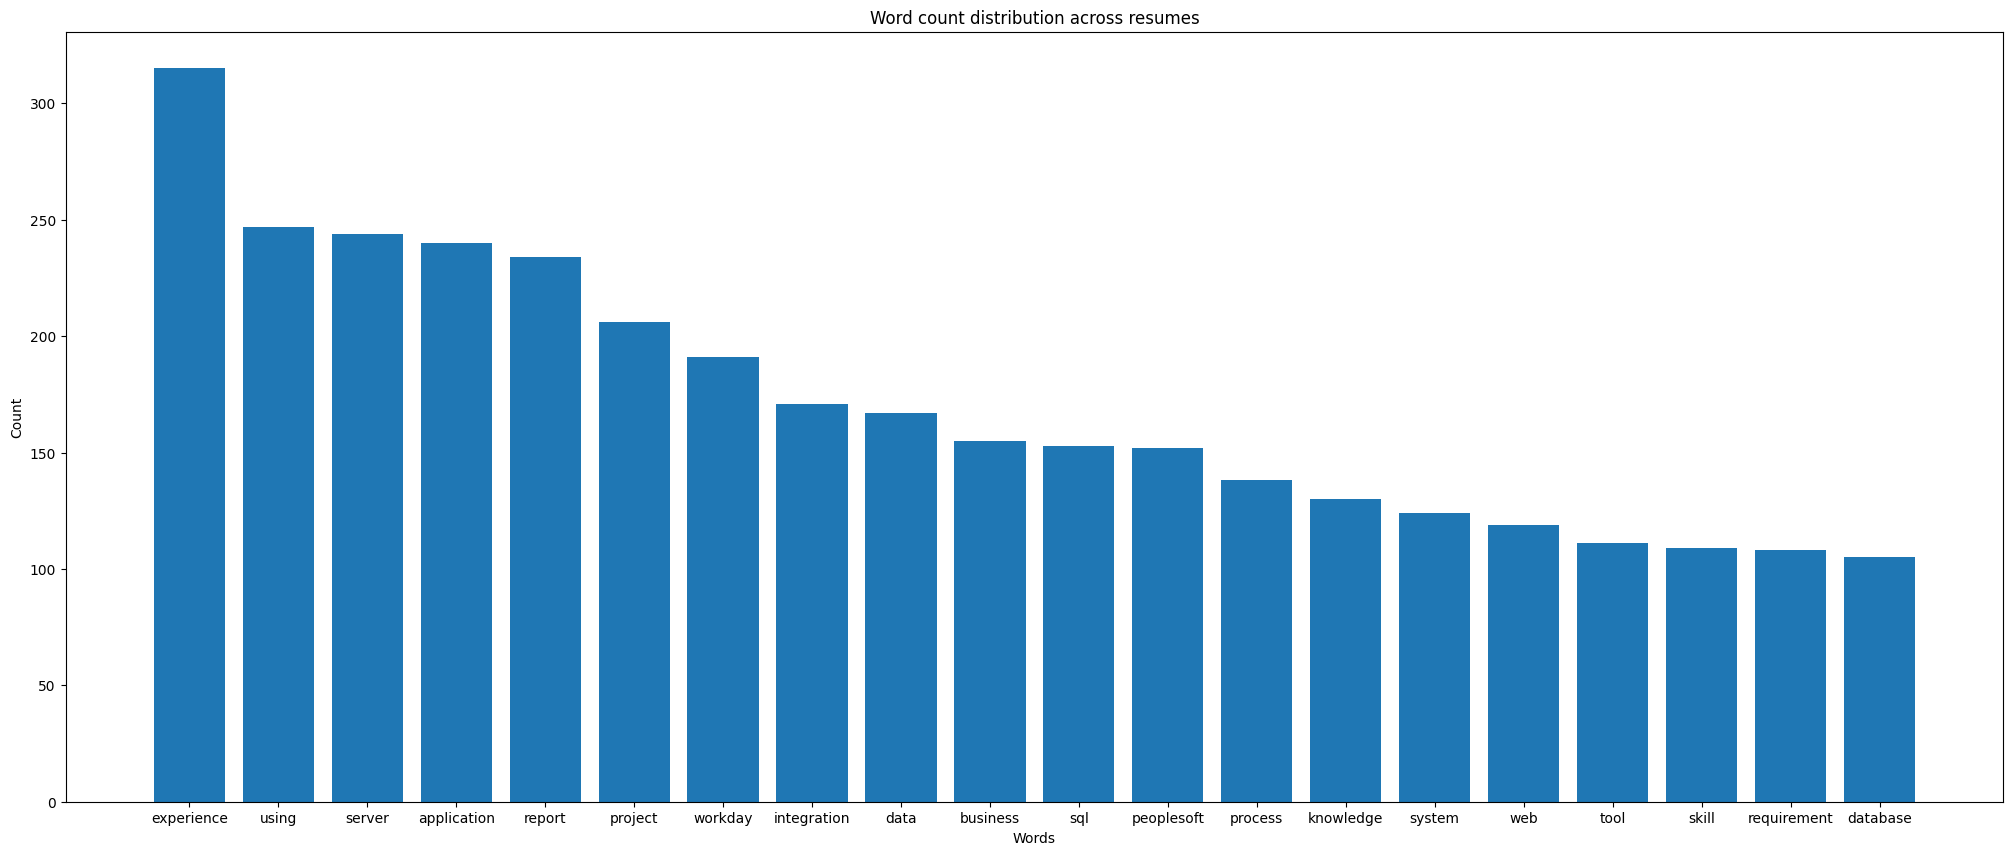

In [19]:
words = df_words_frequency['Words']
wordscount = df_words_frequency['Count']
plt.figure(figsize=(25,10))
plt.bar(words,wordscount)
plt.title("Word count distribution across resumes")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

### Word Cloud

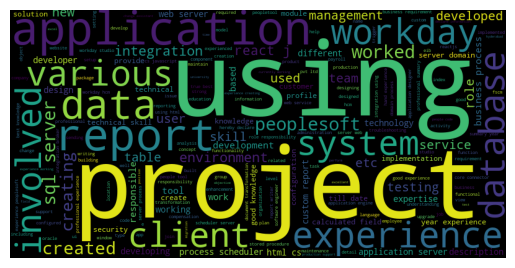

In [20]:
text = " ".join(df_cleaned['text'])
wc = WordCloud(width=800, height=400).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

### Named Entity Recognition using Spacy

In [21]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(" ".join(df_cleaned['text'].sample(5)))
[(ent.text, ent.label_) for ent in doc.ents]

[('jyoti verma year', 'PERSON'),
 ('workday', 'DATE'),
 ('day day', 'DATE'),
 ('workday', 'DATE'),
 ('september', 'DATE'),
 ('day day', 'DATE'),
 ('workday', 'DATE'),
 ('jyoti verma \ue947', 'PERSON'),
 ('feb', 'CARDINAL'),
 ('mar software', 'PERSON'),
 ('daily', 'DATE'),
 ('lok seva', 'PERSON'),
 ('java skill', 'PERSON'),
 ('english', 'LANGUAGE'),
 ('indian', 'NORP'),
 ('kodigenahallihmadhugirittumkurd', 'GPE'),
 ('karnataka hereby declare abovementioned', 'ORG'),
 ('sayana', 'ORG'),
 ('year', 'DATE'),
 ('pum s elastic', 'PERSON'),
 ('weblogic tuxedo people', 'PERSON'),
 ('weblogic tuxedo people', 'PERSON'),
 ('weblogic tuxedo people', 'PERSON'),
 ('weblogic tuxedo oracle g r people', 'PERSON'),
 ('india', 'GPE'),
 ('feb sept', 'DATE'),
 ('india pvt ltd', 'ORG'),
 ('oct', 'CARDINAL'),
 ('jan oct', 'DATE'),
 ('daily', 'DATE'),
 ('daily', 'DATE'),
 ('weekly', 'DATE'),
 ('daily', 'DATE'),
 ('daily', 'DATE'),
 ('weekly', 'DATE'),
 ('weekly', 'DATE'),
 ('oct', 'CARDINAL'),
 ('daily', 'DATE

### Skills Extraction

In [22]:
skills_list = [
    'react','reactjs','javascript','html','css','python','django','flask','node','nodejs',
    'sql','mysql','postgresql','mongodb','aws','azure','docker','kubernetes','git'
]

def extract_skills(text, skills=skills_list):
    text = " " + (text or "") + " "
    found = [s for s in skills if f" {s} " in text or s in text]
    return sorted(set(found))

df_cleaned['skills'] = df_cleaned['text'].apply(extract_skills)
df_cleaned['skills_count'] = df_cleaned['skills'].apply(len)
df_cleaned.iloc[:, [0,4,5]]  # Display selected columns

,filename,skills,skills_count
0,Requirement document- Document Classification ...,[python],1
1,Internship_Ravali_Musquare Technologies (1).docx,[],0
2,Internship_Susovan Bag_Musquare Technologies.docx,"[css, html, javascript, sql]",4
3,React Developer_Deepakreddy.docx,"[html, javascript, react, reactjs]",4
4,React Developer_Haripriya.docx,"[html, javascript, mysql, react, reactjs, sql]",6
5,React Developer_Kamalakar Reddy.docx,"[git, html, javascript, react, reactjs]",5
6,React Developer_Naveen sadhu.docx,"[css, html, node, nodejs, react, reactjs, sql]",7
7,React Developer_Pragnya.docx,"[html, javascript, react]",3
8,React Developer_Sarala Madasu-converted.docx,"[css, html, javascript, react]",4
9,React Developer_Thirupathiamma.docx,"[javascript, react]",2


In [23]:
# Listing the most common skills
skill_counts = Counter([s for sub in df_cleaned['skills'] for s in sub])
pd.DataFrame(skill_counts.most_common(15), columns=['skill','count'])

,skill,count
0,sql,24
1,react,19
2,html,18
3,javascript,16
4,reactjs,10
5,node,10
6,mysql,8
7,git,8
8,aws,4
9,python,3


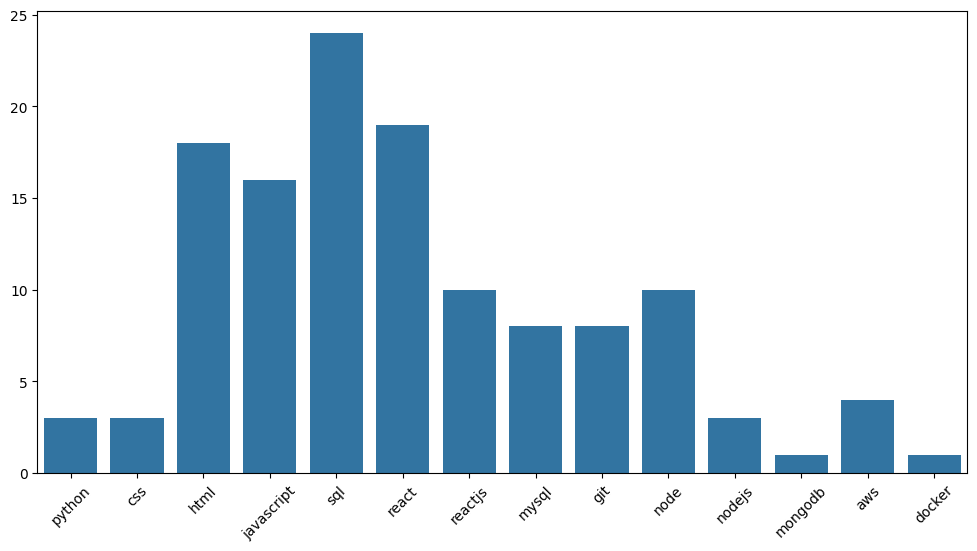

In [24]:
# Plotting skills distribution
plt.figure(figsize=(12,6))
sns.barplot(x=list(skill_counts.keys()), y=list(skill_counts.values()))
plt.xticks(rotation=45)
plt.show()


## Model Buidling

### Model 1: Naive Bayes

#### Defining and extracting variables

In [25]:
# Filterwanings import warnings
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Assign labels - internship', 'react developer', 'react dev', 'react js developer','reactjs developer', 'peoplesoft admin', 'peoplesoft dba','peoplesoft fscm',
def extract_label(filename):
    fname = filename.lower()
    # normalize separators to spaces for easier matching
    fname_clean = re.sub(r'[_\-\.\(\)\[\]]+', ' ', fname)
    patterns = [
        'internship',
        'react js developer',
        'reactjs developer',
        'react developer',
        'react dev',
        'peoplesoft fscm',
        'peoplesoft dba',
        'peoplesoft admin'
    ]
    label = 'others'
    for p in patterns:
        if p in fname_clean:
            label = p
            break
    return label
df_cleaned['label'] = df_cleaned['filename'].apply(extract_label)
df_cleaned['label'].unique()

array(['others', 'internship', 'react developer', 'react dev',
       'react js developer', 'reactjs developer', 'peoplesoft admin',
       'peoplesoft dba', 'peoplesoft fscm'], dtype=object)

In [27]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['text'], df_cleaned['label'], test_size=0.2, random_state=42)

In [28]:
# Text Verctorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)  

Accuracy: 45.45%
Classification Report:
                    precision    recall  f1-score   support

            others       0.45      1.00      0.62         5
   react developer       0.00      0.00      0.00         2
react js developer       0.00      0.00      0.00         2
 reactjs developer       0.00      0.00      0.00         2

          accuracy                           0.45        11
         macro avg       0.11      0.25      0.16        11
      weighted avg       0.21      0.45      0.28        11

Confusion Matrix:


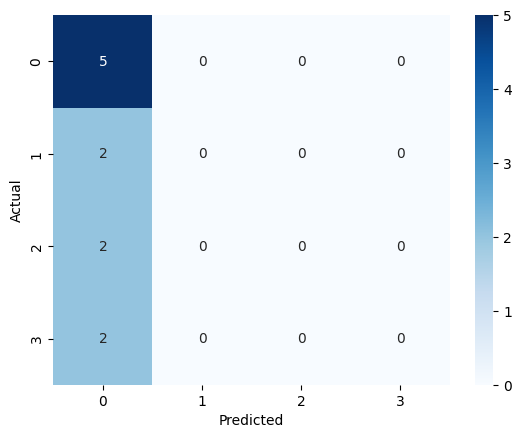

In [29]:
# Train Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train) 

# Predict on test set
y_pred = model.predict(X_test)  

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)   
print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('Actual')        
plt.show()

#### Hyperparameter tuning for Naive Bayes

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'chi2__k': 2000, 'clf': ComplementNB(), 'clf__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Accuracy: 63.64%
                    precision    recall  f1-score   support

            others       1.00      1.00      1.00         5
   react developer       0.25      0.50      0.33         2
react js developer       0.00      0.00      0.00         2
 reactjs developer       0.50      0.50      0.50         2

          accuracy                           0.64        11
         macro avg       0.44      0.50      0.46        11
      weighted avg       0.59      0.64      0.61        11



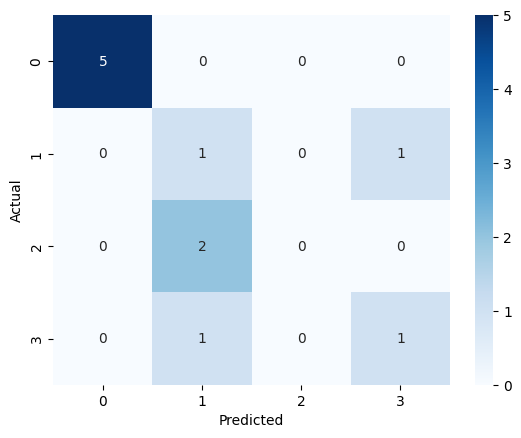

In [31]:

# 1) split raw texts (stratify to preserve label distribution)
X_text_train, X_text_test, y_train, y_test = train_test_split(
    df_cleaned['text'], df_cleaned['label'],
    test_size=0.2, random_state=42
)

# 2) pipeline: TF-IDF -> optional chi2 feature selection -> classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, lowercase=True)),
    ('chi2', SelectKBest(chi2)),   # keep as step for tuning; can be removed to speed up
    ('clf', MultinomialNB())
])

# 3) grid for TF-IDF, chi2 and different classifiers
param_grid = [
    # MultinomialNB / ComplementNB grid
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [MultinomialNB()],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [ComplementNB()],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    # linear SVM
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [LinearSVC(max_iter=10000)],
        'clf__C': [0.1, 1, 10]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)

# 4) fit search on training split
gs.fit(X_text_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_

# 5) evaluate on test split
y_pred = best.predict(X_text_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()



#### Feature importances (top 20) after TF-IDF vectorizer with Hyperparamter tuning

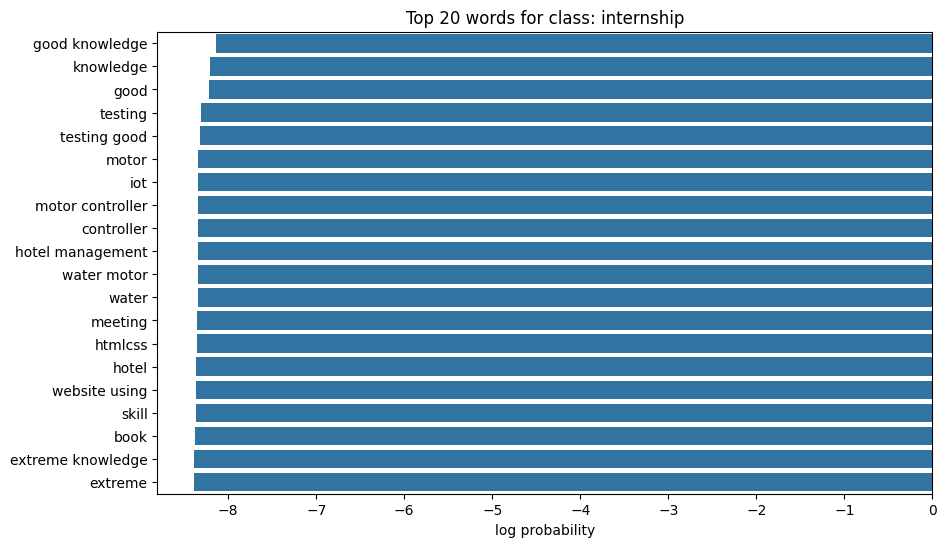

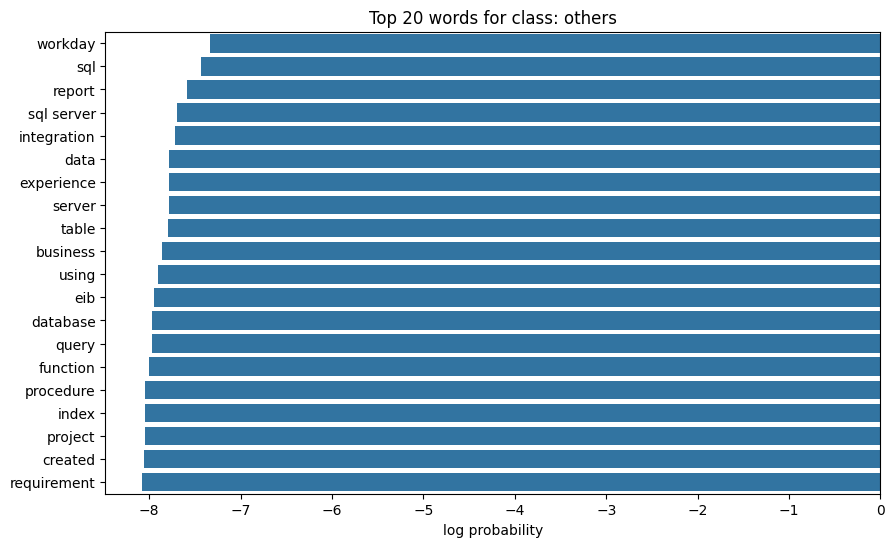

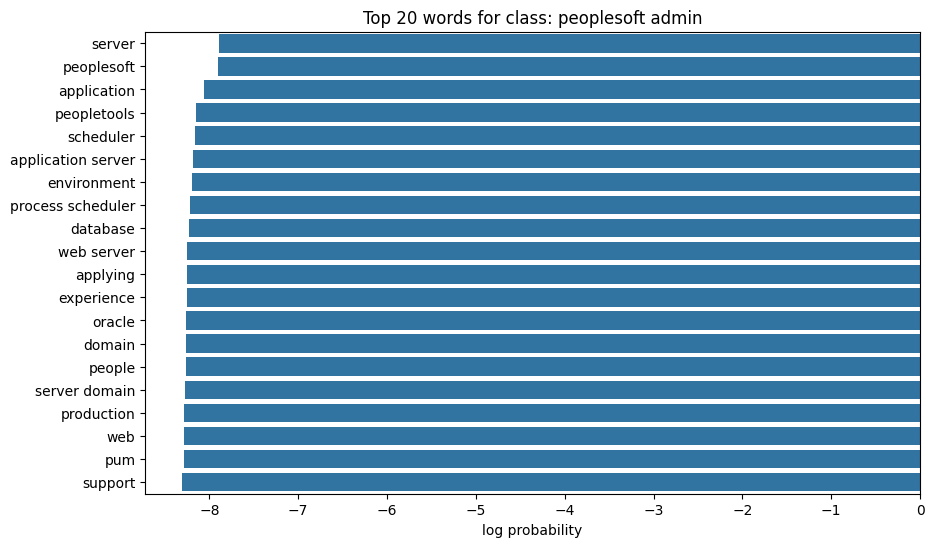

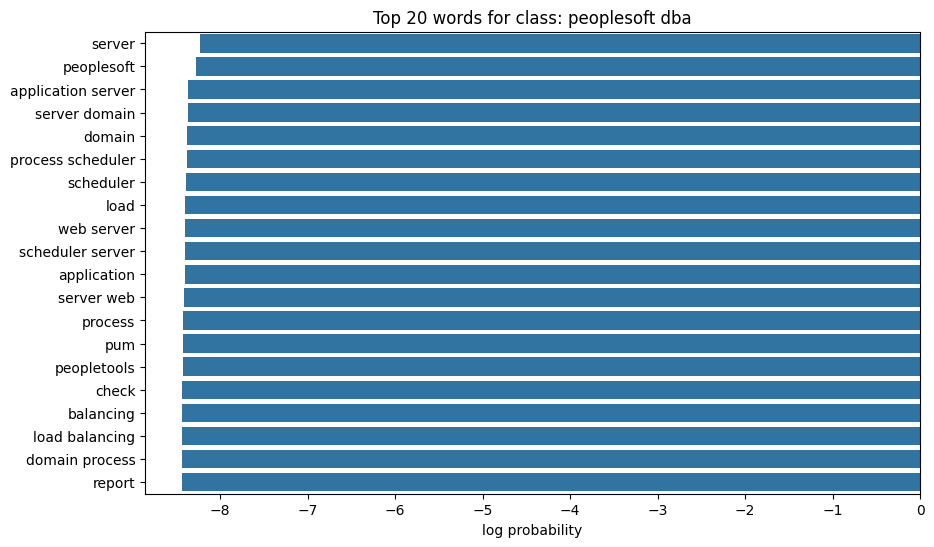

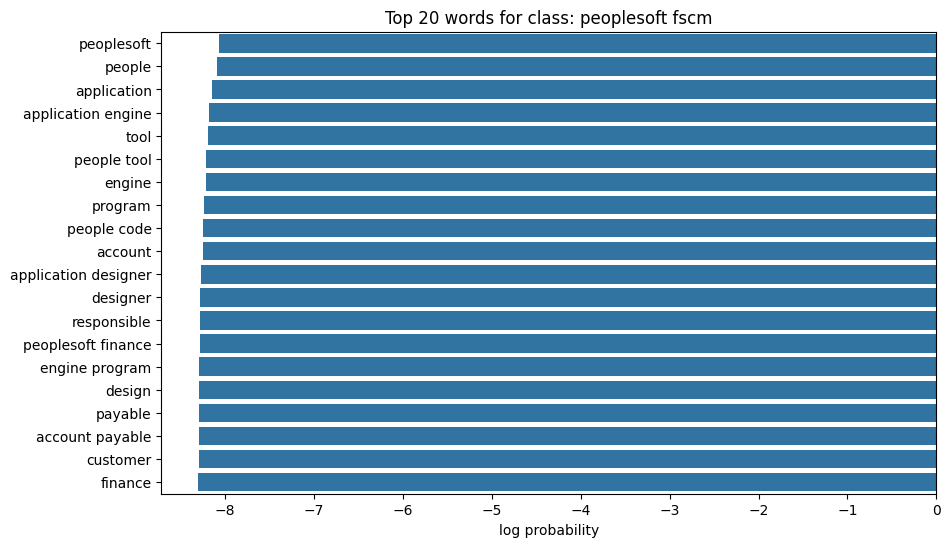

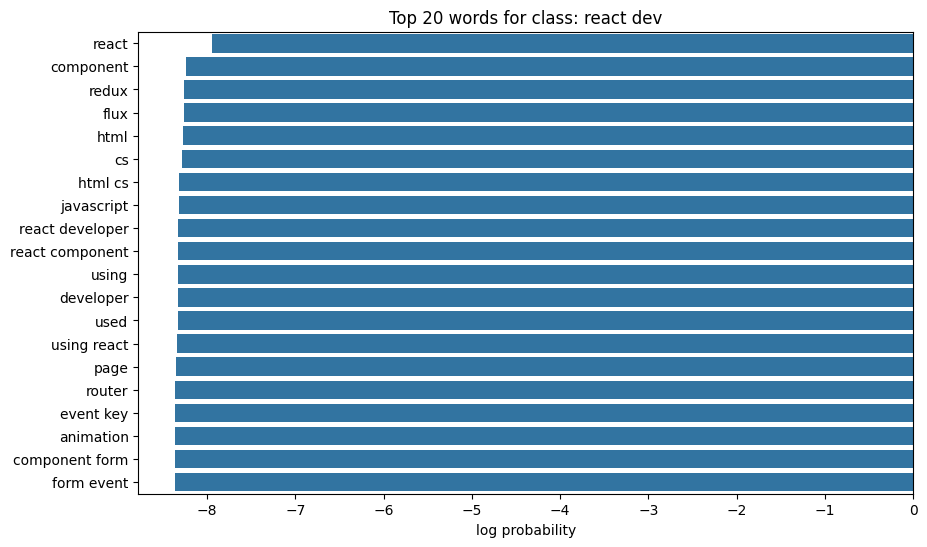

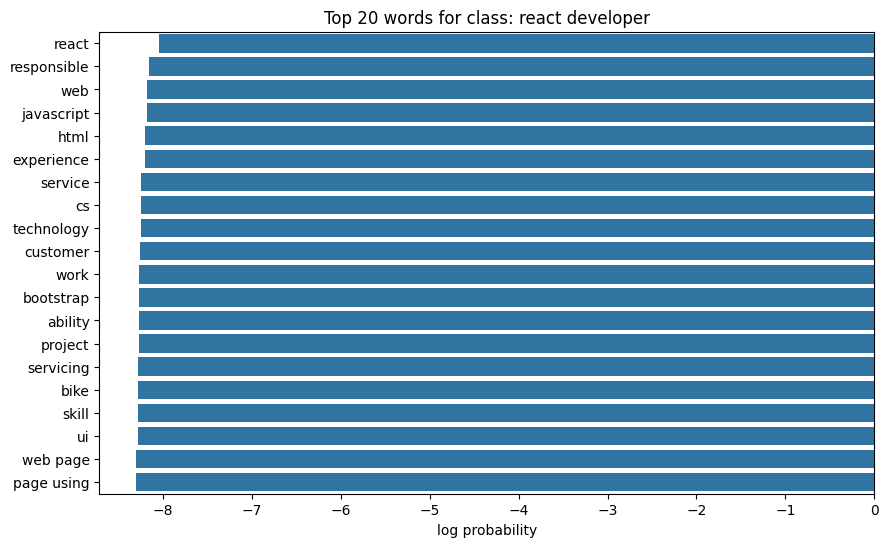

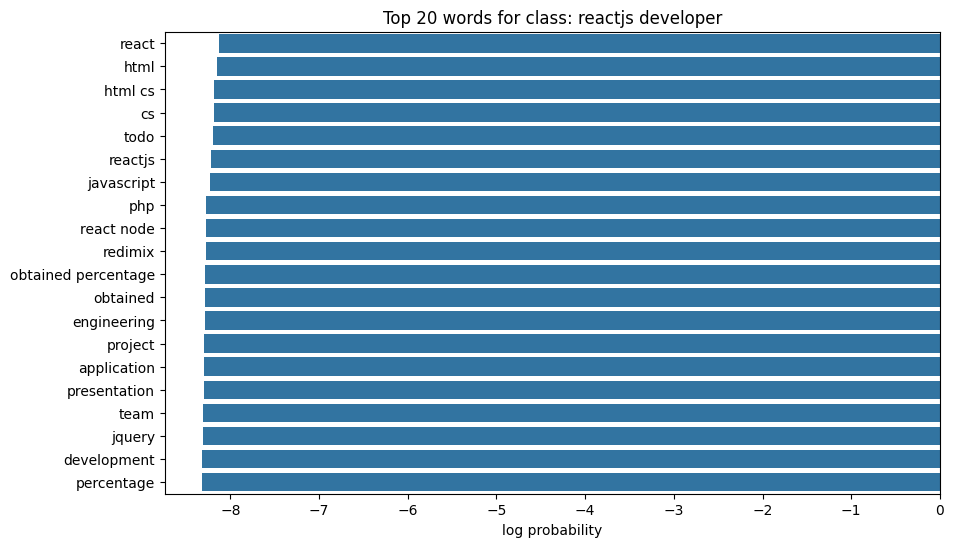

In [35]:
# Get feature names
try:
    if 'vectorizer' in globals():
        fnames = vectorizer.get_feature_names_out()
    elif 'best' in globals() and hasattr(best, 'named_steps') and 'tfidf' in best.named_steps:
        fnames = best.named_steps['tfidf'].get_feature_names_out()
    else:
        fnames = None
except:
    fnames = None

if fnames is None:
    print("Feature names unavailable — cannot extract top words.")
else:
    # Naive Bayes feature scores
    scores = model.feature_log_prob_

    for i, class_label in enumerate(model.classes_):
        idx = np.argsort(scores[i])[-20:][::-1]  # top 20
        top_feats = fnames[idx]
        top_scores = scores[i][idx]

        plt.figure(figsize=(10,6))
        sns.barplot(x=top_scores, y=top_feats)
        plt.title(f"Top 20 words for class: {class_label}")
        plt.xlabel("log probability")
        plt.show()


#### ROC Curve for Naive Bayes 

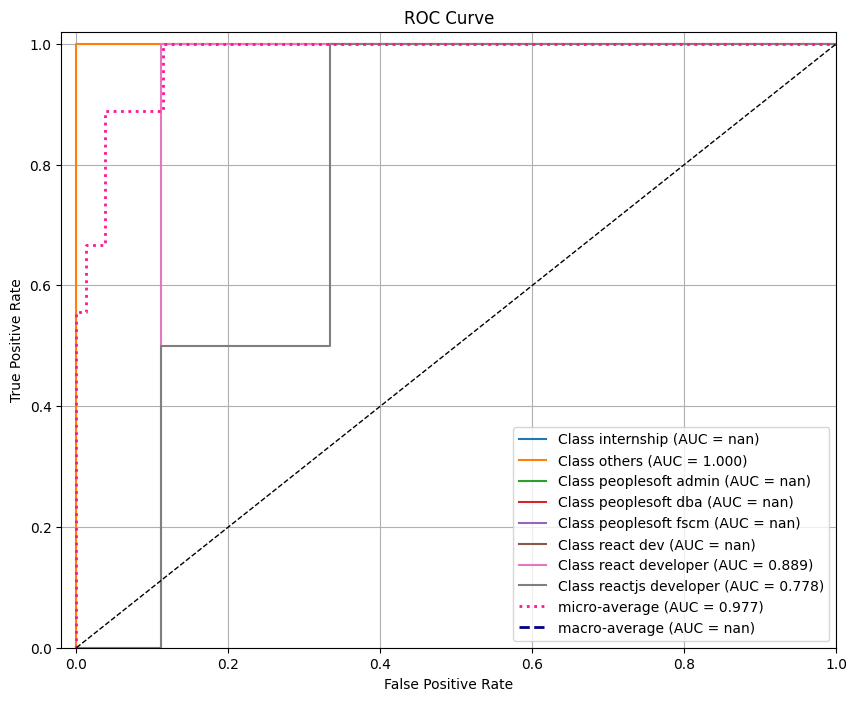

In [36]:
# get prediction scores
try:
    y_score = best.predict_proba(X_text_test)
except Exception:
    # some classifiers (LinearSVC) don't have predict_proba but have decision_function
    y_score = best.decision_function(X_text_test)

# prepare true labels
classes = list(best.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
n_classes = Y.shape[1]

plt.figure(figsize=(10, 8))

# Binary case: y_score may be 1D or (n_samples,2)
if y_score.ndim == 1 or (y_score.ndim == 2 and y_score.shape[1] == 1):
    # single score per sample (binary)
    scores = y_score.ravel()
    fpr, tpr, _ = roc_curve(y_test_array == classes[1] if len(classes)>1 else y_test_array, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
else:
    # Multiclass: compute per-class ROC and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {cls} (AUC = {roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC = {roc_auc["micro"]:.3f})')

    # macro-average
    # aggregate all fpr points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC = {roc_auc["macro"]:.3f})')

# plot chance line and formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Model 2: Random Forest with ROC curve

Random Forest Accuracy: 63.64%
                    precision    recall  f1-score   support

            others       0.71      1.00      0.83         5
   react developer       0.00      0.00      0.00         2
react js developer       0.00      0.00      0.00         2
 reactjs developer       0.50      1.00      0.67         2

          accuracy                           0.64        11
         macro avg       0.30      0.50      0.38        11
      weighted avg       0.42      0.64      0.50        11



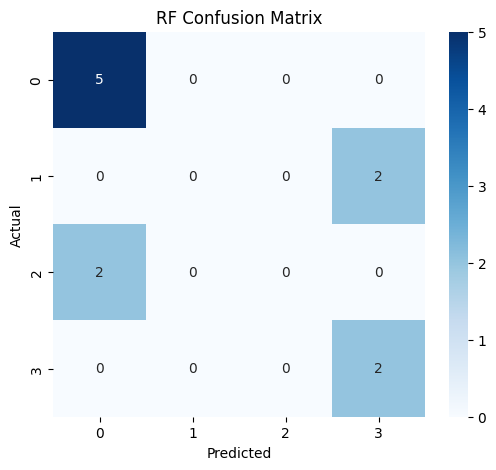

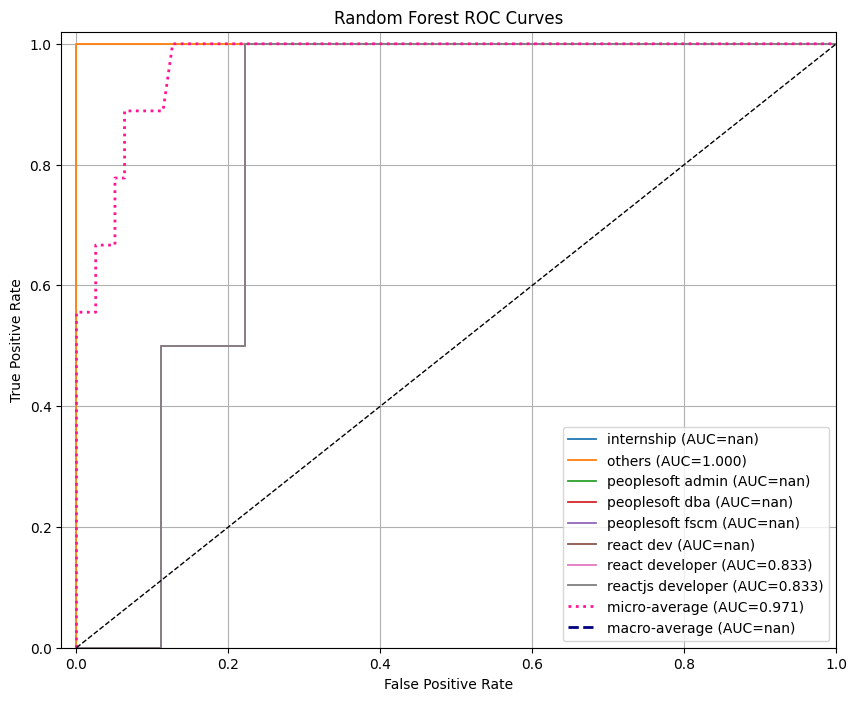

In [37]:
# Train Random Forest (adjust n_estimators / max_depth as needed)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predictions & evaluation
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf*100:.2f}%")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('RF Confusion Matrix')
plt.show()

# ROC / AUC (multiclass: per-class, micro and macro)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
try:
    y_score_rf = rf.predict_proba(X_test)
except Exception:
    # fallback (shouldn't be needed for RandomForest, but safe)
    y_score_rf = rf.decision_function(X_test)

classes = list(rf.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
if Y.shape[1] == 0:
    print("ROC: label binarize failed (check labels).")
else:
    n_classes = Y.shape[1]
    plt.figure(figsize=(10,8))

    # per-class
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score_rf[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.3, label=f'{cls} (AUC={roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score_rf.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC={roc_auc["micro"]:.3f})')

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC={roc_auc["macro"]:.3f})')

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([-0.02,1.0]); plt.ylim([0.0,1.02])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curves')
    plt.legend(loc='lower right'); plt.grid(True); plt.show()

### Model 3: Gradient Boosting with ROC curve

Gradient Boosting Accuracy: 54.55%
                    precision    recall  f1-score   support

            others       1.00      1.00      1.00         5
   react developer       0.20      0.50      0.29         2
react js developer       0.00      0.00      0.00         2
 reactjs developer       0.00      0.00      0.00         2

          accuracy                           0.55        11
         macro avg       0.30      0.38      0.32        11
      weighted avg       0.49      0.55      0.51        11



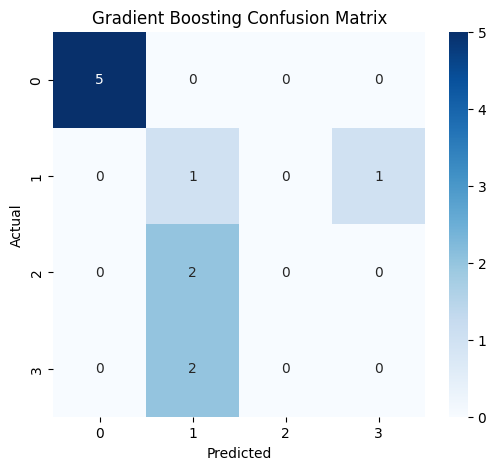

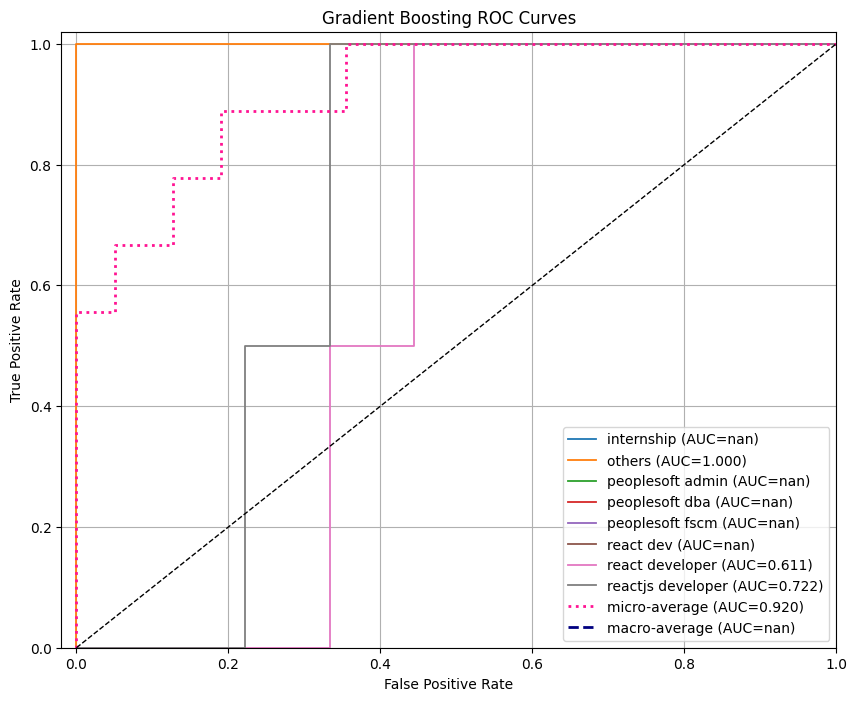

In [38]:
# Train Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
# some sklearn GB implementations may not accept sparse matrices -> convert if needed
try:
    gb.fit(X_train, y_train)
except Exception:
    gb.fit(X_train.toarray(), y_train)

# Predictions and evaluation
try:
    y_pred_gb = gb.predict(X_test)
except Exception:
    y_pred_gb = gb.predict(X_test.toarray())

acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {acc_gb*100:.2f}%")
print(classification_report(y_test, y_pred_gb, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Gradient Boosting Confusion Matrix')
plt.show()

# ROC / AUC (multiclass: per-class, micro and macro)
try:
    y_score_gb = gb.predict_proba(X_test)
except Exception:
    y_score_gb = gb.predict_proba(X_test.toarray())

classes = list(gb.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
if Y.shape[1] == 0:
    print("ROC: label binarize failed (check labels).")
else:
    n_classes = Y.shape[1]
    plt.figure(figsize=(10,8))

    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score_gb[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.3, label=f'{cls} (AUC={roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score_gb.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC={roc_auc["micro"]:.3f})')

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC={roc_auc["macro"]:.3f})')

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([-0.02,1.0]); plt.ylim([0.0,1.02])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curves')
    plt.legend(loc='lower right'); plt.grid(True); plt.show()

### Model 4: K-Means with Silhouette Score

Cluster sizes:
0     2
1    14
2     1
3     3
4     2
5     1
6     5
7    11
8    15
Name: count, dtype: int64

Contingency table (labels vs clusters):
col_0               0   1  2  3  4  5  6   7  8
label                                          
internship          0   1  0  1  0  0  0   0  0
others              1  10  1  0  0  0  0  11  0
peoplesoft admin    0   0  0  0  0  0  4   0  0
peoplesoft dba      0   0  0  0  0  0  1   0  0
peoplesoft fscm     0   3  0  0  2  0  0   0  0
react dev           0   0  0  0  0  0  0   0  2
react developer     1   0  0  2  0  0  0   0  4
react js developer  0   0  0  0  0  0  0   0  2
reactjs developer   0   0  0  0  0  1  0   0  7

Silhouette score: 0.1109

Top terms per cluster:
Cluster 0: final presentation, participant, timeline, classification, final, human, presentation, servicing, bike, extended documentation
Cluster 1: sql, sql server, server, table, database, function, query, data, index, experience
Cluster 2: data, retail, cube, super

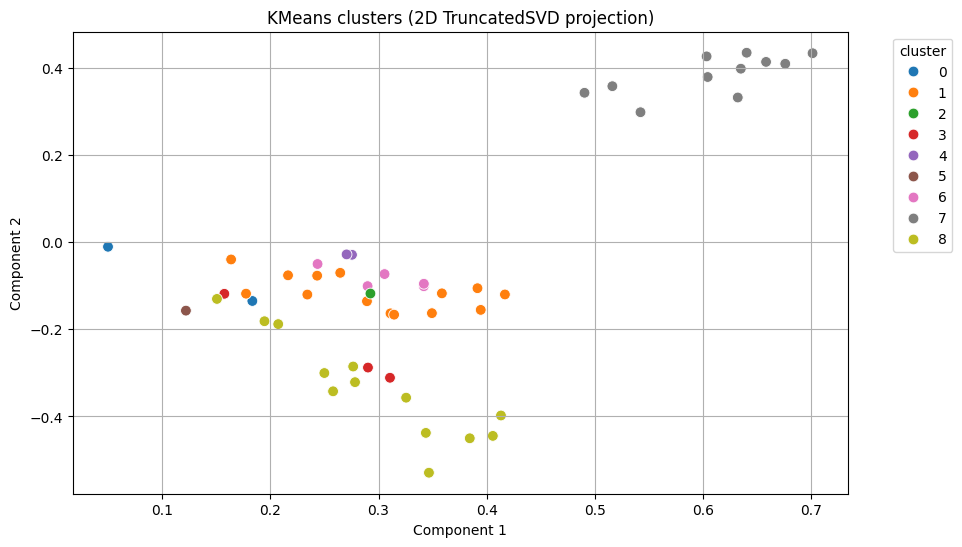

In [39]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build TF-IDF for all documents (vectorizer already fitted)
X_all = vectorizer.transform(df_cleaned['text'])

# Choose clusters = number of known labels (or set manually)
n_clusters = max(2, df_cleaned['label'].nunique())

# Fit MiniBatchKMeans (works with sparse TF-IDF)
km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
km.fit(X_all)
cluster_ids = km.labels_

# Basic cluster diagnostics
print("Cluster sizes:")
print(pd.Series(cluster_ids).value_counts().sort_index())

# Compare clusters to ground-truth labels
print("\nContingency table (labels vs clusters):")
print(pd.crosstab(df_cleaned['label'], cluster_ids))

# Silhouette score (sampled for speed if dataset is large)
try:
    sil = silhouette_score(X_all, cluster_ids, sample_size=min(1000, X_all.shape[0]), random_state=42)
    print(f"\nSilhouette score: {sil:.4f}")
except Exception as e:
    print("Silhouette score computation failed:", e)

# Top terms per cluster
try:
    terms = vectorizer.get_feature_names_out()
    centers = km.cluster_centers_
    order = centers.argsort()[:, ::-1]
    print("\nTop terms per cluster:")
    for i in range(n_clusters):
        top_terms = [terms[idx] for idx in order[i, :10]]
        print(f"Cluster {i}: {', '.join(top_terms)}")
except Exception as e:
    print("Top-terms extraction failed:", e)

# 2D visualization using TruncatedSVD (works with sparse matrices)
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_all)

plt.figure(figsize=(10,6))
palette = sns.color_palette("tab10", n_clusters)
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=cluster_ids, palette=palette, legend='full', s=60)
plt.title('KMeans clusters (2D TruncatedSVD projection)')
plt.xlabel('Component 1'); plt.ylabel('Component 2')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Optionally add cluster id back to dataframe
df_cleaned['km_cluster'] = cluster_ids
# ...existing code...

### Model comparison based on F1 score

                  accuracy  f1_weighted
model                                  
NaiveBayes        0.636364     0.606061
RandomForest      0.636364     0.500000
GradientBoosting  0.545455     0.506494
KMeans            0.636364     0.545455


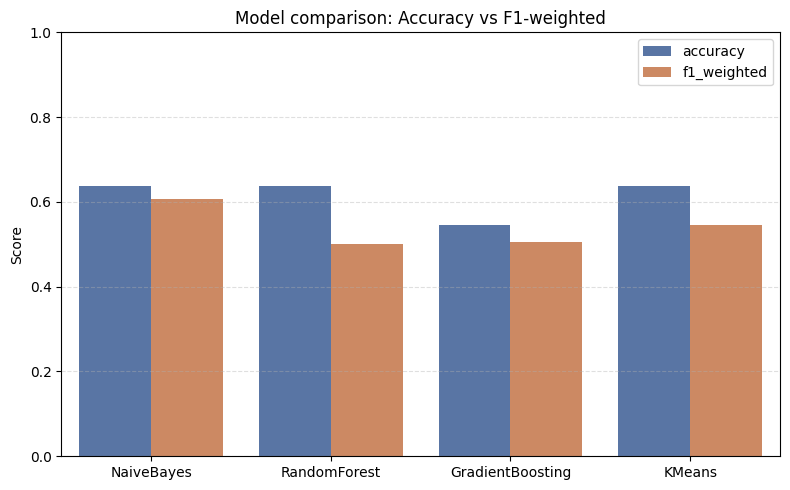

Best model by F1-weighted: NaiveBayes (F1=0.606)
Naive Bayes selected because it gave best F1; it performs well on text (multinomial) with TF-IDF


In [40]:
# Ensure supervised models predictions exist; compute if not
y_pred_nb = model.predict(X_test) if 'y_pred' not in globals() else y_pred
y_pred_rf = rf.predict(X_test) if 'y_pred_rf' not in globals() else y_pred_rf
y_pred_gb = gb.predict(X_test) if 'y_pred_gb' not in globals() else y_pred_gb

# Metrics for supervised models
scores = []
for name, ypred in [('NaiveBayes', y_pred_nb), ('RandomForest', y_pred_rf), ('GradientBoosting', y_pred_gb)]:
    acc = accuracy_score(y_test, ypred)
    f1w = f1_score(y_test, ypred, average='weighted', zero_division=0)
    scores.append({'model': name, 'accuracy': acc, 'f1_weighted': f1w})

# KMeans (train on X_train, predict on X_test, map clusters -> most common train label)
n_clusters = max(2, df_cleaned['label'].nunique())
km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
# fit may fail on sparse -> convert to dense if needed
try:
    km.fit(X_train)
    train_clusters = km.predict(X_train)
    test_clusters = km.predict(X_test)
except Exception:
    km.fit(X_train.toarray())
    train_clusters = km.predict(X_train.toarray())
    test_clusters = km.predict(X_test.toarray())

# build mapping cluster -> most common label in training set
cluster_label_map = {}
for c in np.unique(train_clusters):
    labels_in_cluster = np.array(y_train)[train_clusters == c]
    if labels_in_cluster.size == 0:
        continue
    most_common = Counter(labels_in_cluster).most_common(1)[0][0]
    cluster_label_map[c] = most_common

# map test clusters to predicted labels (fallback to 'others' if unknown)
y_pred_km = [cluster_label_map.get(c, 'others') for c in test_clusters]

acc_km = accuracy_score(y_test, y_pred_km)
f1w_km = f1_score(y_test, y_pred_km, average='weighted', zero_division=0)
scores.append({'model': 'KMeans', 'accuracy': acc_km, 'f1_weighted': f1w_km})

# Results dataframe
df_scores = pd.DataFrame(scores).set_index('model')
print(df_scores)

# Plot comparison (accuracy and f1_weighted)
df_plot = df_scores.reset_index().melt(id_vars='model', value_vars=['accuracy', 'f1_weighted'],
                                       var_name='metric', value_name='score')

plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x='model', y='score', hue='metric', palette='deep')
plt.title('Model comparison: Accuracy vs F1-weighted')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('')
plt.legend(title='')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Choose best by f1_weighted and short inference
best = df_scores['f1_weighted'].idxmax()
print(f"Best model by F1-weighted: {best} (F1={df_scores.loc[best,'f1_weighted']:.3f})")

# Short inference (printed)
if best in ['RandomForest', 'GradientBoosting']:
    print(f"{best} selected because it achieved the highest weighted F1. Ensemble tree models")
    print("handle high-dimensional TF-IDF features, capture non-linear patterns and are robust to noisy")
    print("features and class imbalance (with class_weight or ensemble averaging).")
elif best == 'NaiveBayes':
    print("Naive Bayes selected because it gave best F1; it performs well on text (multinomial) with TF-IDF")
else:
    print("KMeans (unsupervised) performed best by this metric — verify supervised comparison and labels.")


## Save model for deployment

In [41]:
joblib.dump(best, 'best_resume_model.joblib')

['best_resume_model.joblib']

Deployment using Streamlit

2025-11-25 16:32:45.973 
  command:

    streamlit run c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-25 16:32:45.986 Session state does not function when running a script without `streamlit run`
